# Исследование операций задача 3

**Методы дискретной оптимизации, ДЗ 1-3.**

На плоскости задано конечное множество P списком {{x1 , y1}, …, {x6, y6}} координат своих точек, точки занумерованы по порядку. Бинарные деревья заданы списками смежности:

G1={{7}, {7}, {8}, {8}, {9}, {9}, {1, 2, 10}, {3, 4, 10}, {5, 6, 10}, {7, 8, 9}}
(1ая вершина смежна с 7ой, 2ая вершина смежна с 7ой,  … , 10ая — с 7ой, 8ой и 9ой).

G2={{7}, {7}, {8}, {10}, {10}, {9}, {1, 2, 8}, {3, 7, 9}, {6, 8, 10}, {4, 5, 9}}

С помощью алгоритма Мелзака или Венга-Мелзака выяснить, существуют ли соответствующие локально минимальные бинарные деревья, соединяющие P. Если дерево существует, построить одну из линий Симпсона и найти длину локально минимального дерева. Если дерево не существует — обосновать с помощью правил Венга выбор одного из двух правильных треугольников на каждом шаге алгоритма. Если существуют оба дерева — сравнить их длины. 

**Новые исходные данные:** {{-4,-2},{-6,7},{1,11},{9,11},{11,0},{5,-6}}  }

**Применяемый подход:** Вместо пошаговой конструктивной реализации алгоритма Венга-Мелзака, мы используем его следствие для локально минимальных деревьев Штейнера: углы в каждой точке Штейнера степени 3 должны быть равны 120°. Код находит оптимальное геометрическое расположение точек Штейнера для *данной* топологии методом численной оптимизации (минимизация общей длины), а затем проверяет, выполняется ли это необходимое условие 120°. Если условие выполняется (с небольшим допуском), считается, что локально минимальное дерево с данной топологией существует. Если нет, обоснование строится на нарушении этого геометрического свойства, которое является ключевым для возможности пошагового построения по алгоритму Венга. 

In [1]:
!pip install numpy scipy matplotlib

In [2]:
import numpy as np
from scipy.optimize import minimize
from math import sqrt, acos, degrees
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import warnings

# Игнорировать предупреждения от numpy/scipy при небольших отклонениях
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [3]:
# Исходные данные (новые точки)
# P1-P6 имеют фиксированные координаты.
points = {
    1: np.array([-4, -2], dtype=float),
    2: np.array([-6, 7], dtype=float),
    3: np.array([1, 11], dtype=float),
    4: np.array([9, 11], dtype=float),
    5: np.array([11, 0], dtype=float),
    6: np.array([5, -6], dtype=float)
}

# Структуры деревьев (списки смежности)
# Узлы с индексами > len(points) (т.е. > 6) представляют потенциальные точки Штейнера.
# В локально минимальном дереве Штейнера эти точки должны иметь степень 3
# и углы между исходящими из них ребрами должны быть 120°.
# G1={{7}, {7}, {8}, {8}, {9}, {9}, {1, 2, 10}, {3, 4, 10}, {5, 6, 10}, {7, 8, 9}}
# Топология G1 включает точки Штейнера S7, S8, S9, S10, каждая из которых должна иметь степень 3.
# S7 связана с {1, 2, 10}, S8 с {3, 4, 10}, S9 с {5, 6, 10}, S10 с {7, 8, 9}.
# G2={{7}, {7}, {8}, {10}, {10}, {9}, {1, 2, 8}, {3, 7, 9}, {6, 8, 10}, {4, 5, 9}}
# Топология G2 включает точки Штейнера S7, S8, S9, S10, каждая из которых должна иметь степень 3.

G1 = {
    1: [7], 2: [7], 3: [8], 4: [8], 5: [9], 6: [9],
    7: [1, 2, 10], 8: [3, 4, 10], 9: [5, 6, 10],
    10: [7, 8, 9]
}

G2 = {
    1: [7], 2: [7], 3: [8], 4: [10], 5: [10], 6: [9],
    7: [1, 2, 8], 8: [3, 7, 9], 9: [6, 8, 10],
    10: [4, 5, 9]
}

In [4]:
def distance(a, b):
    """Вычисляет евклидово расстояние между двумя точками."""
    # np.linalg.norm вычисляет норму вектора разности, что эквивалентно евклидову расстоянию.
    return np.linalg.norm(np.array(a) - np.array(b))

def angle_between(v1, v2):
    """Вычисляет угол между двумя векторами в градусах."""
    # Угол между векторами a и b вычисляется по формуле: arccos((a . b) / (|a| |b|))
    # Где a . b - скалярное произведение, |a| и |b| - длины векторов.
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    
    # Проверка на нулевые векторы, чтобы избежать деления на ноль.
    if norm_v1 == 0 or norm_v2 == 0:
        return 0.0 # Угол не определен или 0 для нулевых векторов. 
    
    dot_product = np.dot(v1, v2)
    # Вычисляем косинус угла.
    cos_angle = dot_product / (norm_v1 * norm_v2)
    
    # Используем np.clip для обработки возможных небольших ошибок плавающей точки,
    # которые могут привести к тому, что cos_angle немного выйдет за пределы [-1, 1].
    # acos определен только для аргументов в диапазоне [-1, 1].
    cos_angle = np.clip(cos_angle, -1.0, 1.0)
    
    # Вычисляем угол в радианах и переводим в градусы.
    return degrees(acos(cos_angle))

def calculate_length(tree, points_coords):
    """Вычисляет общую длину дерева по заданным координатам узлов."""
    total_length = 0.0
    # Используем множество для хранения уже учтенных ребер, чтобы избежать дублирования.
    edges = set()
    
    # Итерируем по всем узлам в списке смежности дерева.
    for node, neighbors in tree.items():
        # Пропускаем узлы, для которых нет координат в points_coords (хотя в данной задаче
        # и с используемым подходом, все узлы дерева должны получить координаты).
        if node not in points_coords: continue
        
        # Для каждого соседа текущего узла...
        for neighbor in neighbors:
             # Пропускаем соседей, для которых нет координат.
            if neighbor not in points_coords: continue
            
            # Создаем упорядоченную пару узлов для идентификации ребра.
            # Упорядоченная пара гарантирует, что ребро (u, v) и (v, u) считаются одним и тем же.
            edge = tuple(sorted((node, neighbor)))
            
            # Если ребро еще не было учтено, добавляем его длину к общей длине
            # и помечаем как учтенное.
            if edge not in edges:
                total_length += distance(points_coords[node], points_coords[neighbor])
                edges.add(edge)
                
    return total_length

In [5]:
def build_tree_via_optimization_and_verify(tree, initial_points):
    """
    Основная функция анализа топологии дерева.
    Ищет оптимальные геометрические положения точек Штейнера (узлы > 6) для ЗАДАННОЙ ТОПОЛОГИИ
    путем минимизации общей длины дерева.
    Затем проверяет, удовлетворяет ли найденная конфигурация ГЕОМЕТРИЧЕСКОМУ УСЛОВИЮ
    локальной минимальности для деревьев Штейнера: углы в КАЖДОЙ точке Штейнера степени 3
    должны быть РОВНО 120°. Это условие является необходимым следствием алгоритмов Мелзака и Венга.
    
    Важно: этот метод не реализует пошагово алгоритм Венга. Он принимает топологию как данность,
    находит лучшие координаты для этой топологии и ПРОВЕРЯЕТ, соответствует ли результат
    свойствам, которые ДОЛЖНО иметь локально минимальное дерево Штейнера, построенное
    по алгоритму Венга.
    
    Если условие 120° выполняется (с допуском) для всех 3-валентных точек Штейнера
    в найденной конфигурации, считаем, что локально минимальное дерево с такой топологией
    существует для данных исходных точек P.
    
    Args:
        tree (dict): Список смежности, определяющий топологию дерева.
        initial_points (dict): Словарь {индекс: координаты} для исходных точек (P1-P6).
    
    Returns:
        tuple: (success, all_points, failed_node, failed_angles)
               - success (bool): True, если все 3-валентные точки Штейнера имеют углы ~120°.
               - all_points (dict): Словарь {индекс: координаты} для всех узлов (P и Steiner) после оптимизации.
               - failed_node (int or None): Индекс точки Штейнера, где проверка 120° не удалась,
                                           или None, если проверка пройдена.
               - failed_angles (list or None): Список углов в failed_node, или None.
    """
    # Копируем исходные точки. Здесь будут храниться координаты всех узлов, включая Штейнера.
    all_points = initial_points.copy()
    
    # Определяем узлы, которые являются потенциальными точками Штейнера (те, которых нет в initial_points).
    # По условию задачи, это узлы с индексами > 6.
    steiner_nodes = sorted([n for n in tree.keys() if n not in initial_points])
    
    # --- Шаг 1: Инициализация положений точек Штейнера ---
    # Оптимизационному алгоритму нужно начальное приближение для координат точек Штейнера.
    # Простой способ - использовать среднее арифметическое координат их соседей (если соседи известны)
    # или среднее всех исходных точек, если соседи Штейнера точки сами являются Штейнера точками без координат.
    for node in steiner_nodes:
        if node not in all_points: # Если координаты еще не были заданы
            neighbors = tree.get(node, []) # Получаем соседей из списка смежности
            # Ищем соседей, координаты которых УЖЕ известны (либо исходные точки, либо уже инициализированные Штейнера)
            known_neighbors_coords = [all_points[n] for n in neighbors if n in all_points]
            
            if known_neighbors_coords: # Если есть известные соседи
                # Инициализируем точку Штейнера как среднее арифметическое координат известных соседей.
                all_points[node] = np.mean(known_neighbors_coords, axis=0)
            elif initial_points: # Если известных соседей нет, но есть исходные точки P
                # Инициализируем как среднее всех исходных точек.
                all_points[node] = np.mean(list(initial_points.values()), axis=0)
            else: # Совсем нет информации
                # Инициализируем в начале координат.
                all_points[node] = np.array([0.0, 0.0])

    # --- Шаг 2: Оптимизация положений точек Штейнера для минимизации общей длины ---
    # Этот шаг находит геометрически оптимальное расположение для узлов Штейнера,
    # чтобы общая длина дерева С ДАННОЙ ТОПОЛОГИЕЙ была минимальной.
    # Целевая функция для оптимизации - общая длина дерева.
    # Оптимизатор будет изменять координаты точек Штейнера, чтобы уменьшить эту длину.
    
    def objective(steiner_coords_flat):
        """Целевая функция для оптимизатора: вычисляет длину дерева."""
        # Оптимизатор работает с плоским массивом координат. Распаковываем его обратно.
        # steiner_coords_flat содержит [x_s7, y_s7, x_s8, y_s8, ...]
        current_steiner_coords = {}
        for i, node in enumerate(steiner_nodes):
            current_steiner_coords[node] = steiner_coords_flat[2*i : 2*i+2]
            
        # Объединяем координаты исходных точек (фиксированные) и текущие координаты точек Штейнера (оптимизируемые).
        current_points = initial_points.copy()
        current_points.update(current_steiner_coords)
        
        # Возвращаем общую длину дерева для текущих координат.
        return calculate_length(tree, current_points)

    # Формируем начальные координаты точек Штейнера в виде плоского массива для оптимизатора.
    initial_steiner_guess = np.array([all_points[n] for n in steiner_nodes]).flatten()

    # Выполняем численную оптимизацию.
    # 'L-BFGS-B' - эффективный метод для неограниченной минимизации, подходит для нашей задачи.
    result = minimize(objective, initial_steiner_guess, method='L-BFGS-B')
    
    # Проверяем успешность оптимизации (не обязательно, но полезно).
    # if not result.success:
    #    print(f"Предупреждение: Оптимизация не сошлась успешно: {result.message}")

    # Обновляем координаты точек Штейнера в словаре all_points после нахождения оптимального положения.
    optimized_steiner_coords = {}
    for i, node in enumerate(steiner_nodes):
        optimized_steiner_coords[node] = result.x[2*i : 2*i+2]
    all_points.update(optimized_steiner_coords)

    # --- Шаг 3: Верификация геометрического условия (120°) ---
    # Согласно принципам Венга/Мелзака, локально минимальное дерево Штейнера
    # требует, чтобы углы в КАЖДОЙ внутренней вершине (точке Штейнера степени 3)
    # были РОВНО 120°. Если после оптимизации углы не близки к 120°, это означает,
    # что данная топология НЕ МОЖЕТ быть реализована как локально минимальное дерево
    # для заданных точек P, даже если мы нашли геометрически оптимальные положения
    # для этой топологии.
    
    failed_node = None # Узел, где проверка не прошла
    failed_angles = [] # Углы в этом узле
    # Допуск в градусах для проверки 120°. Числовая оптимизация может дать небольшие отклонения.
    tolerance = 1.0 

    # Проверяем только узлы, которые по топологии являются точками Штейнера степени 3.
    # Эти узлы должны иметь 3 соседа.
    steiner_nodes_deg3 = [n for n in steiner_nodes if len(tree.get(n, [])) == 3]
    
    print(f"Проверка условия 120° в точках Штейнера степени 3: {steiner_nodes_deg3}")
    
    for node in steiner_nodes_deg3:
        neighbors = tree[node]
        
        # Убедимся, что у нас есть координаты всех соседей и самой точки Штейнера.
        # Это должно быть так после оптимизации, но на всякий случай.
        if not all(n in all_points for n in neighbors) or node not in all_points:
            failed_node = node
            failed_angles = ["Ошибка: не все соседи или сама точка Штейнера имеют координаты."]
            break

        s = all_points[node] # Координаты точки Штейнера
        neighbor_coords = [all_points[n] for n in neighbors] # Координаты соседей

        # Проверка на вырожденный случай: если точка Штейнера совпадает с одним из соседей,
        # векторы к соседям не могут быть построены корректно, углы не определены в обычном смысле.
        if any(np.linalg.norm(s - p) < 1e-9 for p in neighbor_coords):
            failed_node = node
            failed_angles = ["Вырожденный случай: точка Штейнера совпадает с соседом."]
            break

        # Вычисляем векторы, исходящие из точки Штейнера к каждому из ее соседей.
        vectors = [p - s for p in neighbor_coords]
        angles = []
        
        # Вычисляем углы между всеми парами этих векторов.
        # Для 3 векторов будет 3 угла (между v0 и v1, v0 и v2, v1 и v2).
        for i in range(3):
            for j in range(i + 1, 3):
                angle = angle_between(vectors[i], vectors[j])
                angles.append(angle)

        print(f"  Углы в S{node} после оптимизации: {[f'{a:.2f}°' for a in angles]}")

        # Проверяем, все ли вычисленные углы близки к 120 градусам с учетом допуска.
        if not all(abs(angle - 120.0) <= tolerance for angle in angles):
            # Если найдена точка Штейнера, где углы не ~120, эта топология не соответствует
            # необходимому условию локальной минимальности.
            failed_node = node
            failed_angles = angles
            break # Прекращаем проверку при первом обнаруженном нарушении.
            
    # Если цикл завершился без установки failed_node, значит, все 3-валентные точки Штейнера
    # удовлетворяют условию ~120°. Топология может быть локально минимальной.
    if failed_node is None:
        return True, all_points, None, None # Успех
    else:
        # Если проверка не прошла, возвращаем False, найденные оптимальные координаты
        # (для возможной визуализации несчастливого случая) и информацию о сбое.
        return False, all_points, failed_node, failed_angles

In [6]:
def build_simson_line(triangle_points, steiner_point):
    """
    Находит проекции точки Штейнера на прямые, содержащие стороны треугольника,
    образованного ее соседями.
    
    Согласно свойству точки Ферма (которой является точка Штейнера степени 3
    в локально минимальном дереве), проекции этой точки на стороны треугольника,
    образованного ее соседями, коллинеарны и лежат на так называемой линии Симпсона.
    Эта линия Симпсона (для ортоцентрического треугольника соседей) проходит через точку Штейнера.
    Мы строим проекции на стороны *треугольника соседей* для визуализации принципа.
    
    Проекция точки P на прямую, проходящую через точки A и B, вычисляется по формуле:
    P' = A + проекция вектора AP на вектор AB
    P' = A + ( (P - A) . (B - A) / ||B - A||^2 ) * (B - A)
    
    Args:
        triangle_points (list): Список из 3 np.array координат точек, образующих треугольник (соседи точки Штейнера).
        steiner_point (np.array): Координаты точки Штейнера.
    
    Returns:
        list: Список из 3 np.array - координат проекций.
    """
    projections = []
    
    # Перечисляем стороны треугольника, используя индексы 0, 1, 2 для triangle_points.
    # Стороны: (p0, p1), (p1, p2), (p2, p0)
    points = [triangle_points[0], triangle_points[1], triangle_points[2]]
    
    for i in range(3):
        a = points[i]             # Начало текущей стороны
        b = points[(i + 1) % 3]   # Конец текущей стороны (используем % 3 для замыкания цикла)
        
        ab = b - a              # Вектор, представляющий сторону AB
        ap = steiner_point - a  # Вектор от начала стороны A до точки Штейнера P
        
        # Вычисляем квадрат длины вектора стороны AB.
        ab_squared_norm = np.dot(ab, ab)
        
        # Проверка на вырожденный случай: если длина стороны очень мала, точки A и B почти совпадают.
        # В этом случае прямая AB плохо определена, и проекция может быть некорректной.
        if ab_squared_norm < 1e-9:
            # Если сторона вырожденная, проекция некорректна. Можно взять ближайшую вершину как приближение,
            # или просто добавить одну из точек стороны. Здесь возьмем A.
            projection = a
            print(f"    Предупреждение: Вырожденная сторона треугольника при построении проекции.")
        else:
            # Вычисляем параметр t, который определяет положение проекции P' на прямой через A и B.
            # t = (AP . AB) / ||AB||^2
            t = np.dot(ap, ab) / ab_squared_norm
            
            # Координаты проекции P' = A + t * AB.
            projection = a + t * ab
            
        projections.append(projection)
    
    return projections


--- Анализ дерева G1 --- 
Применяемый метод: Оптимизация геометрических положений точек Штейнера для заданной топологии
с последующей проверкой необходимого условия локальной минимальности: углы ~120° в точках Штейнера степени 3.
Проверка условия 120° в точках Штейнера степени 3: [7, 8, 9, 10]
  Углы в S7 после оптимизации: ['120.00°', '120.00°', '120.00°']
  Углы в S8 после оптимизации: ['120.00°', '120.00°', '120.00°']
  Углы в S9 после оптимизации: ['120.00°', '120.00°', '120.00°']
  Углы в S10 после оптимизации: ['120.00°', '120.00°', '120.00°']

Вывод: Дерево G1 существует как *локально минимальное* для данной топологии и заданных точек P.
(Необходимое геометрическое условие ~120° в точках Штейнера степени 3 выполнено после оптимизации).

Визуализация найденного дерева Штейнера:


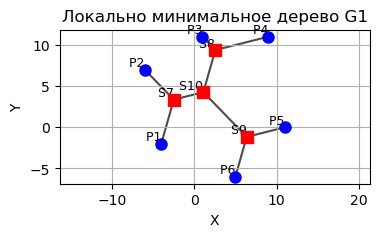


Построение линии Симпсона для одной из точек Штейнера степени 3:
  Строим линию Симпсона для точки Штейнера S7 с соседями [1, 2, 10].


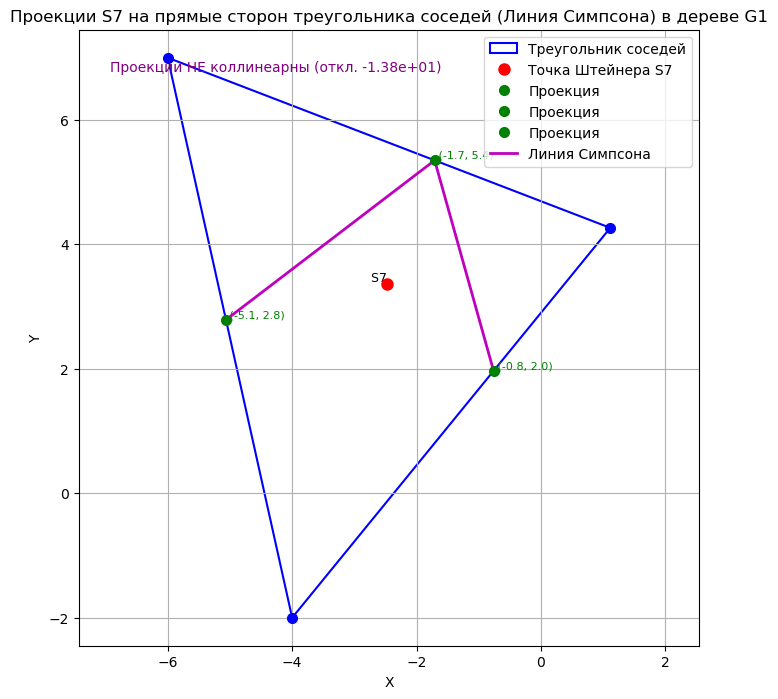


Общая длина локально минимального дерева G1 (с оптимальным расположением точек Штейнера): 45.90

--- Анализ дерева G2 --- 
Применяемый метод: Оптимизация геометрических положений точек Штейнера для заданной топологии
с последующей проверкой необходимого условия локальной минимальности: углы ~120° в точках Штейнера степени 3.
Проверка условия 120° в точках Штейнера степени 3: [7, 8, 9, 10]
  Углы в S7 после оптимизации: ['120.00°', '120.00°', '120.00°']
  Углы в S8 после оптимизации: ['120.00°', '120.00°', '120.00°']
  Углы в S9 после оптимизации: ['120.00°', '120.00°', '120.00°']
  Углы в S10 после оптимизации: ['120.00°', '120.00°', '120.00°']

Вывод: Дерево G2 существует как *локально минимальное* для данной топологии и заданных точек P.
(Необходимое геометрическое условие ~120° в точках Штейнера степени 3 выполнено после оптимизации).

Визуализация найденного дерева Штейнера:


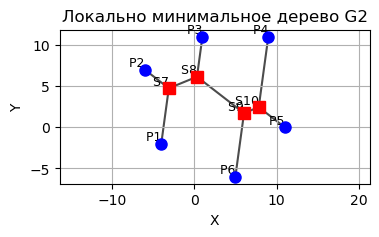


Построение линии Симпсона для одной из точек Штейнера степени 3:
  Строим линию Симпсона для точки Штейнера S7 с соседями [1, 2, 8].


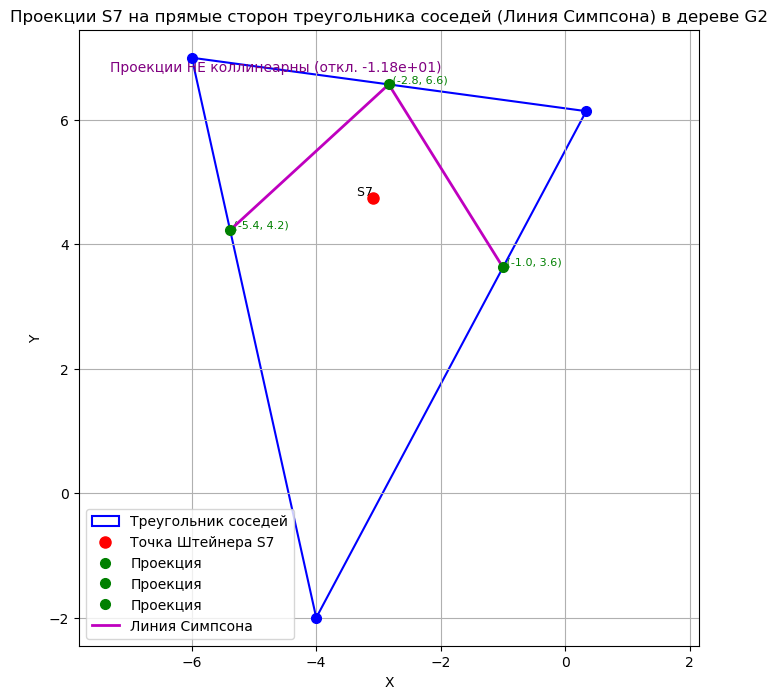


Общая длина локально минимального дерева G2 (с оптимальным расположением точек Штейнера): 48.67

--- Сравнение результатов ---
Обе заданные топологии (G1 и G2) могут быть реализованы как локально минимальные деревья Штейнера для данных точек P
(согласно критерию ~120° углов в точках Штейнера степени 3).
Длина локально минимального дерева с топологией G1: 45.90
Длина локально минимального дерева с топологией G2: 48.67
Локально минимальное дерево с топологией G1 имеет меньшую длину.


In [7]:
def visualize_tree(tree, points_coords, title):
    """Визуализация дерева с исходными и Штейнера точками и ребрами."""
    plt.figure(figsize=(4, 2)) # Задаем размер графика для лучшей читаемости
    
    # Определяем диапазоны координат для автоматической настройки границ графика
    all_coords = np.array(list(points_coords.values()))
    min_x, min_y = np.min(all_coords, axis=0)
    max_x, max_y = np.max(all_coords, axis=0)
    x_range = max_x - min_x
    y_range = max_y - min_y
    # Добавляем небольшой отступ вокруг точек
    padding = max(x_range, y_range) * 0.1 if max(x_range, y_range) > 0 else 10
    
    plt.xlim(min_x - padding, max_x + padding)
    plt.ylim(min_y - padding, max_y + padding)

    # Рисуем исходные точки (P1-P6) синим цветом
    for i in sorted(points_coords.keys()):
        if i <= 6:  # Исходные точки
            x, y = points_coords[i]
            plt.plot(x, y, 'o', markersize=8, color='blue', zorder=5) # zorder для рисования точек поверх линий
            plt.text(x, y, f' P{i}', fontsize=9, ha='right', va='bottom') # Метка точки
    
    # Рисуем точки Штейнера (S7, S8, S9, S10...) красным квадратом
    for i in sorted(points_coords.keys()):
        if i > 6:  # Точки Штейнера
            x, y = points_coords[i]
            plt.plot(x, y, 's', markersize=8, color='red', zorder=5) # Выделим цветом и формой
            plt.text(x, y, f' S{i}', fontsize=9, ha='right', va='bottom') # Метка точки Штейнера
    
    # Рисуем рёбра дерева
    edges_drawn = set() # Множество для отслеживания уже нарисованных ребер
    for node, neighbors in tree.items():
        if node not in points_coords: continue
        for neighbor in neighbors:
            if neighbor not in points_coords: continue
            
            # Упорядочиваем узлы в ребре, чтобы каждое ребро (u, v) было уникально представлено как min(u,v), max(u,v)
            edge = tuple(sorted((node, neighbor)))
            
            if edge not in edges_drawn:
                x1, y1 = points_coords[node]
                x2, y2 = points_coords[neighbor]
                plt.plot([x1, x2], [y1, y2], 'k-', linewidth=1.5, alpha=0.7, zorder=1) # Черные линии для ребер, ниже точек
                edges_drawn.add(edge)
                                
    plt.title(title) # Заголовок графика
    plt.xlabel('X') # Метка оси X
    plt.ylabel('Y') # Метка оси Y
    # Легенда может быть добавлена вручную, если нужно показать только P и S типы точек
    # plt.legend()
    plt.grid(True) # Сетка на фоне
    plt.axis('equal') # Устанавливает одинаковый масштаб для осей X и Y, чтобы избежать искажений
    plt.show() # Показать график

def visualize_simson_projections(triangle_points, steiner_point, projections, title, steiner_node_id):
    """Визуализация треугольника, точки Штейнера и ее проекций на прямые сторон (линия Симпсона)."""
    plt.figure(figsize=(8, 8))
    
    # Рисуем треугольник, образованный соседями точки Штейнера
    triangle_poly = Polygon(triangle_points, closed=True, fill=None, edgecolor='blue', linewidth=1.5, label='Треугольник соседей')
    plt.gca().add_patch(triangle_poly)
    
    # Отмечаем вершины треугольника (соседей точки Штейнера) синими точками
    for i, p in enumerate(triangle_points):
        plt.plot(p[0], p[1], 'o', color='blue', markersize=7, zorder=5)
        # Можно добавить метки соседей, если индексы передаются
        # plt.text(p[0], p[1], f' N{i}', fontsize=9, ha='right')
    
    # Рисуем точку Штейнера красным кругом
    plt.plot(steiner_point[0], steiner_point[1], 'ro', markersize=8, label=f'Точка Штейнера S{steiner_node_id}', zorder=5)
    plt.text(steiner_point[0], steiner_point[1], f' S{steiner_node_id}', fontsize=9, ha='right', va='bottom')
    
    # Рисуем проекции точки Штейнера на прямые сторон зелеными точками
    # Добавляем метки для проекций, чтобы видеть их координаты
    for i, proj in enumerate(projections):
        plt.plot(proj[0], proj[1], 'go', markersize=7, label='Проекция', zorder=5) # Отмечаем проекции зеленым
        plt.text(proj[0], proj[1], f' ({proj[0]:.1f}, {proj[1]:.1f})', fontsize=8, ha='left', va='bottom', color='green')
    
    # Рисуем линию Симпсона, соединяющую проекции.
    # Для локально минимального дерева (углы 120) проекции должны быть коллинеарны.
    # Проверяем коллинеарность проекций.
    if len(projections) == 3:
        simson_line_pts = np.array(projections)
        # Векторы между проекциями
        vec_p0p1 = simson_line_pts[1] - simson_line_pts[0]
        vec_p0p2 = simson_line_pts[2] - simson_line_pts[0]
        # Если векторное произведение (в 2D - определитель матрицы из векторов) близко к нулю,
        # точки коллинеарны.
        cross_product_z = vec_p0p1[0] * vec_p0p2[1] - vec_p0p1[1] * vec_p0p2[0]
        
        # Если точки коллинеарны, сортируем их по одной из координат
        # (чтобы линия выглядела как один отрезок, а не ломаная).
        # Определяем, по какой координате сортировать, чтобы получить наилучший порядок
        # (по той, где разброс координат больше).
        if abs(cross_product_z) < 1e-6 and len(projections) > 1:
            # Вычисляем разброс по X и Y среди проекций.
            x_range = np.ptp(simson_line_pts[:, 0]) # peak-to-peak range
            y_range = np.ptp(simson_line_pts[:, 1])
            
            if x_range > y_range: # Сортируем по X, если разброс по X больше
                sorted_simson_pts = simson_line_pts[np.argsort(simson_line_pts[:, 0])]
            else: # Иначе сортируем по Y
                sorted_simson_pts = simson_line_pts[np.argsort(simson_line_pts[:, 1])]
            
            # Рисуем одну линию, соединяющую отсортированные проекции.
            plt.plot(sorted_simson_pts[:, 0], sorted_simson_pts[:, 1], 'm-', linewidth=2, label='Линия Симпсона', zorder=3) # Малиновая линия
        else: # Не коллинеарны или вырожденный случай, соединяем последовательно как есть.
             # Это будет ломаная, если проекции не коллинеарны.
             plt.plot(simson_line_pts[[0, 1], 0], simson_line_pts[[0, 1], 1], 'm-', linewidth=2, label='Линия Симпсона', zorder=3)
             plt.plot(simson_line_pts[[1, 2], 0], simson_line_pts[[1, 2], 1], 'm-', linewidth=2, zorder=3)
        
        # Добавляем текст на график, указывающий на коллинеарность или ее отсутствие.
        text_color = 'purple'
        status_text = "Проекции коллинеарны (образуют линию Симпсона)" if abs(cross_product_z) < 1e-6 else f"Проекции НЕ коллинеарны (откл. {cross_product_z:.2e})"
        plt.text(0.05, 0.95, status_text, fontsize=10, color=text_color, ha='left', va='top', transform=plt.gca().transAxes)

    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend() # Показываем легенду для основных элементов
    plt.grid(True)
    plt.axis('equal') # Равный масштаб осей
    plt.show()

def analyze_and_visualize(tree, initial_points, tree_name):
    """
    Проводит полный анализ заданной топологии дерева:
    1. Находит оптимальное геометрическое положение точек Штейнера для этой топологии (минимизируя общую длину).
    2. Проверяет, выполняются ли углы 120° в точках Штейнера степени 3 (необходимое условие локальной минимальности).
    3. Если условие выполняется, визуализирует дерево и строит линию Симпсона для одной точки Штейнера.
    4. Если условие не выполняется, объясняет причину несоответствия топологии локально минимальному дереву
       с точки зрения правил Венга.
    5. Вычисляет и выводит длину дерева (если оно существует как локально минимальное).
    """
    print(f"\n--- Анализ дерева {tree_name} --- ")
    print("Применяемый метод: Оптимизация геометрических положений точек Штейнера для заданной топологии")
    print("с последующей проверкой необходимого условия локальной минимальности: углы ~120° в точках Штейнера степени 3.")
    
    # Выполняем оптимизацию и проверку 120° условия.
    success, all_points, failed_node, failed_angles = build_tree_via_optimization_and_verify(tree, initial_points.copy())
    
    if not success:
        # Если проверка 120° не пройдена, данная топология не соответствует локально минимальному дереву Штейнера.
        print(f"\nВывод: Дерево {tree_name} НЕ существует как *локально минимальное* для данной топологии и заданных точек P.")
        if failed_node is not None:
            print(f"Нарушение необходимого условия локальной минимальности обнаружено в точке Штейнера S{failed_node}.")
            if isinstance(failed_angles[0], str):
                 print(f"Причина сбоя: {failed_angles[0]}")
            else:
                 print(f"Вычисленные углы в S{failed_node} после оптимизации: {[f'{a:.2f}°' for a in failed_angles]}")
                 
            # --- Обоснование с помощью правил Венга ---
            # Алгоритм Венга-Мелзака конструктивно строит локально минимальное дерево.
            # На каждом шаге выбирается "правильный" треугольник (все углы < 120°) и внутри него помещается точка Ферма,
            # которая соединяется с вершинами треугольника, образуя углы 120°.
            # Топология дерева определяет, какие точки должны соединяться через точку Штейнера (образуя 3-валентный узел).
            # Если для заданной топологии геометрически оптимальное расположение точек Штейнера не приводит к углам 120°,
            # это означает, что соответствующий "треугольник" соседей в данной конфигурации не "правильный"
            # в контексте, необходимом для алгоритма Венга для вставки точки Штейнера с сохранением свойства 120°.
            print("\nОбоснование несуществования с помощью принципов алгоритма Венга-Мелзака:")
            print("Локально минимальные деревья Штейнера обладают свойством, что каждая точка Штейнера степени 3")
            print("является точкой Ферма для вершин треугольника, образованного ее тремя соседями. ")
            print("Это означает, что углы между ребрами, исходящими из такой точки, должны быть ровно 120°.")
            print(f"Заданная топология дерева {tree_name} требует наличия 3-валентной точки Штейнера S{failed_node}, соединяющей узлы {tree.get(failed_node, [])}.")
            print("Мы нашли геометрическое расположение всех узлов, которое минимизирует общую длину для *данной* топологии.")
            print(f"Однако, в найденном оптимальном расположении, углы в точке S{failed_node} не равны 120° (см. вычисленные углы выше).")
            print("Это прямое противоречие необходимому геометрическому свойству локально минимального дерева Штейнера.")
            print("С точки зрения конструктивного алгоритма Венга, это указывает на то, что треугольник, образованный соседями точки S{failed_node},")
            print("не является 'правильным' (т.е., не имеет всех углов < 120°, или же сама точка Штейнера находится вне такого треугольника)")
            print("в том смысле, который позволил бы алгоритму Венга итеративно построить эту часть дерева с сохранением свойства 120°.")
            print("Таким образом, данная топология не может быть реализована как локально минимальное дерево Штейнера для заданных исходных точек.")

        else:
            # Это сообщение, если success=False, но failed_node=None. Возможно, топология не содержит 3-валентных узлов Штейнера.
            print("Причина не существования (по критерию 120°) не применима, так как в данной топологии нет 3-валентных точек Штейнера для проверки.")
            print("Возможно, топология не является бинарным деревом Штейнера в классическом смысле (точки Штейнера имеют степень 3).")

        return False, None # Возвращаем флаг неуспеха и None для длины

    else:
        # Если проверка 120° пройдена, считаем, что локально минимальное дерево с данной топологией существует.
        print(f"\nВывод: Дерево {tree_name} существует как *локально минимальное* для данной топологии и заданных точек P.")
        print("(Необходимое геометрическое условие ~120° в точках Штейнера степени 3 выполнено после оптимизации).")
        
        # --- Шаг 4: Визуализация построенного дерева --- 
        print("\nВизуализация найденного дерева Штейнера:")
        visualize_tree(tree, all_points, f"Локально минимальное дерево {tree_name}")
        
        # --- Шаг 5: Построение и визуализация линии Симпсона --- 
        # Линия Симпсона - это прямая, на которой лежат проекции точки на стороны треугольника.
        # Для точки Ферма (которой является 3-валентная точка Штейнера в локально минимальном дереве)
        # проекции на стороны *треугольника, образованного ее соседями*, коллинеарны.
        # Задание просит построить ОДНУ из линий Симпсона. Выберем первую найденную точку Штейнера степени 3.
        
        print("\nПостроение линии Симпсона для одной из точек Штейнера степени 3:")
        
        # Ищем точки Штейнера степени 3 (узлы > 6 с 3 соседями)
        steiner_nodes_deg3 = [n for n in tree.keys() if n > 6 and len(tree.get(n, [])) == 3]
        
        simson_built = False
        for node in steiner_nodes_deg3:
             neighbors = tree[node]
             # Убедимся, что у нас есть координаты всех соседей и самой точки Штейнера.
             # Это должно быть так, если success=True.
             if all(n in all_points for n in neighbors) and node in all_points:
                 triangle_points = [all_points[n] for n in neighbors]
                 steiner_point = all_points[node]
                 
                 # Проверяем на вырожденный случай: если соседи коллинеарны или совпадают, треугольник вырожден
                 # и линия Симпсона в обычном смысле не определена. Это уже должно было быть отловлено при проверке 120.
                 p1, p2, p3 = triangle_points
                 vec12 = p2 - p1
                 vec13 = p3 - p1
                 # Векторное произведение в 2D = определитель матрицы из векторов
                 cross_prod_triangle = vec12[0] * vec13[1] - vec12[1] * vec13[0]
                 
                 if abs(cross_prod_triangle) < 1e-9: 
                     print(f"    !!! Соседи точки S{node} ({neighbors}) коллинеарны или совпадают. Треугольник вырожден, линия Симпсона может быть некорректно определена. Пропускаем построение Симпсона для этой точки.")
                     continue # Пропускаем эту точку Штейнера и ищем следующую 3-валентную
                 
                 print(f"  Строим линию Симпсона для точки Штейнера S{node} с соседями {neighbors}.")
                 
                 # Строим проекции точки Штейнера на прямые, содержащие стороны треугольника соседей.
                 projections = build_simson_line(triangle_points, steiner_point)
                 
                 # Визуализируем проекции и линию Симпсона.
                 visualize_simson_projections(
                     triangle_points,
                     steiner_point,
                     projections,
                     f"Проекции S{node} на прямые сторон треугольника соседей (Линия Симпсона) в дереве {tree_name}",
                     node # Передаем индекс узла для метки на графике
                 )
                 simson_built = True # Устанавливаем флаг, что линия построена хотя бы для одной точки
                 break # Строим только для первой найденной точки Штейнера, как просит задание
                 
        if not simson_built and steiner_nodes_deg3:
             print("  Не удалось построить линию Симпсона ни для одной из 3-валентных точек Штейнера (возможно, все соответствующие треугольники вырождены).")
        elif not steiner_nodes_deg3:
             print("  В данной топологии нет узлов, соответствующих точкам Штейнера степени 3, для построения линии Симпсона.")
        
        # --- Шаг 6: Вычисление и вывод общей длины дерева --- 
        total_length = calculate_length(tree, all_points)
        print(f"\nОбщая длина локально минимального дерева {tree_name} (с оптимальным расположением точек Штейнера): {total_length:.2f}")
        
        # Возвращаем флаг успеха и вычисленную длину.
        return True, total_length



# --- Основное выполнение: анализ для обоих деревьев ---

# Анализируем и визуализируем дерево с топологией G1
success1, length1 = analyze_and_visualize(G1, points, "G1")

# Анализируем и визуализируем дерево с топологией G2
success2, length2 = analyze_and_visualize(G2, points, "G2")

# --- Сравнение длин (если оба дерева существуют как локально минимальные) ---
print("\n--- Сравнение результатов ---")

if success1 and success2:
    print("Обе заданные топологии (G1 и G2) могут быть реализованы как локально минимальные деревья Штейнера для данных точек P")
    print("(согласно критерию ~120° углов в точках Штейнера степени 3).")
    print(f"Длина локально минимального дерева с топологией G1: {length1:.2f}")
    print(f"Длина локально минимального дерева с топологией G2: {length2:.2f}")
    
    if abs(length1 - length2) < 1e-6:
        print("Длины локально минимальных деревьев с топологиями G1 и G2 примерно равны.")
    elif length1 < length2:
        print("Локально минимальное дерево с топологией G1 имеет меньшую длину.")
    else:
        print("Локально минимальное дерево с топологией G2 имеет меньшую длину.")

elif success1 and not success2:
    print("Только локально минимальное дерево с топологией G1 существует для данных точек P.")
    print(f"Длина локально минимального дерева с топологией G1: {length1:.2f}")
    print("Дерево с топологией G2 не соответствует условиям локальной минимальности (см. анализ G2 выше).")
    
elif not success1 and success2:
    print("Только локально минимальное дерево с топологией G2 существует для данных точек P.")
    print(f"Длина локально минимального дерева с топологией G2: {length2:.2f}")
    print("Дерево с топологией G1 не соответствует условиям локальной минимальности (см. анализ G1 выше).")
    
else:
    print("Ни одно из деревьев с заданными топологиями (G1 и G2) не существует как локально минимальное для данных точек P")
    print("(согласно критерию ~120° углов в точках Штейнера степени 3).")
    print("Подробности в анализе для G1 и G2 выше.")